<font size="1">
Code based on "Build a Large Language Model From Scratch": <a href="https://www.manning.com/books/build-a-large-language-model-from-scratch">https://www.manning.com/books/build-a-large-language-model-from-scratch</a> by <a href="https://sebastianraschka.com">Sebastian Raschka</a><br>
Code repository: <a href="https://github.com/rasbt/LLMs-from-scratch">https://github.com/rasbt/LLMs-from-scratch</a>
</font>

# Finetuning GPT for Text Classification

In [1]:
from importlib.metadata import version

pkgs = ["matplotlib",
        "numpy",
        "tiktoken",
        "torch",
        "tensorflow", # For OpenAI's pretrained weights
        "pandas"      # Dataset loading
       ]
for p in pkgs:
    print(f"{p} version: {version(p)}")

matplotlib version: 3.8.4
numpy version: 1.26.4
tiktoken version: 0.6.0
torch version: 2.3.0
tensorflow version: 2.16.1
pandas version: 2.2.2


## 1) Preparing the dataset

- We use a dataset conisting of SPAM (label 1) and non-SPAM (label 0) text messages to finetune the LLM to classify them

In [2]:
import pandas as pd

df = pd.read_csv("train.csv")
df

,Label,Text
0,0,Leave it wif me lar... Ü wan to carry meh so h...
1,1,Enjoy the jamster videosound gold club with yo...
2,1,You are being contacted by our dating service ...
3,1,SMS SERVICES For your inclusive text credits p...
4,0,do u think that any girl will propose u today ...
...,...,...
1040,1,You are being contacted by our Dating Service ...
1041,0,"Say this slowly.? GOD,I LOVE YOU &amp; I NEED ..."
1042,1,You can donate £2.50 to UNICEF's Asian Tsunami...
1043,0,Hi good mornin.. Thanku wish u d same..


In [3]:
from spam_classifier_utils import SpamDataset
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
train_dataset = SpamDataset("train.csv", max_length=None, tokenizer=tokenizer)
val_dataset = SpamDataset("validation.csv", max_length=train_dataset.max_length, tokenizer=tokenizer)
test_dataset = SpamDataset("test.csv", max_length=train_dataset.max_length, tokenizer=tokenizer)

In [4]:
import torch
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

## 2) Initializing a model with pretrained weights

In [5]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

In [6]:
# imports from local files
from gpt_download import download_and_load_gpt2
from spam_classifier_utils import GPTModel, load_weights_into_gpt

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

2024-05-01 12:56:06.125211: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-01 12:56:06.881160: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe


- To ensure that the model was loaded corrected, let's double-check that it generates coherent text

In [7]:
from spam_classifier_utils import generate_text_simple

start_context = "Every effort moves you"

tokenizer = tiktoken.get_encoding("gpt2")
encoded = tokenizer.encode(start_context)
encoded_tensor = torch.tensor(encoded).unsqueeze(0)

out = generate_text_simple(
    model=model,
    idx=encoded_tensor,
    max_new_tokens=15,
    context_size=BASE_CONFIG["context_length"]
)
decoded_text = tokenizer.decode(out.squeeze(0).tolist())

print("Output text:", decoded_text)

Output text: Every effort moves you forward.

The first step is to understand the importance of your work


## 3) Adding a classification head

- In this section, we are modifying the pretrained LLM to make it ready for classification finetuning
- Let's take a look at the model architecture first

In [8]:
print(model)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768,

- The goal is to replace and finetune the output layer
- To achieve this, we first freeze the model, meaning that we make all layers non-trainable

In [9]:
for param in model.parameters():
    param.requires_grad = False

- Then, we replace the output layer (`model.out_head`), which originally maps the layer inputs to 50,257 dimensions (the size of the vocabulary)
- Since we finetune the model for binary classification (predicting 2 classes "spam" and "ham"), we can replace the output layer as shown below, which will be trainable by default

In [10]:
torch.manual_seed(123)

num_classes = 2
model.out_head = torch.nn.Linear(in_features=768, out_features=num_classes)

- Technically, it's sufficient to only train the output layer
- However, as I found in [experiments finetuning additional layers](https://magazine.sebastianraschka.com/p/finetuning-large-language-models) can noticeably improve the performance
- So, we are also making the last transformer block and the final `LayerNorm` module connecting the last transformer block to the output layer trainable

In [11]:
for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True

for param in model.final_norm.parameters():
    param.requires_grad = True

## 4) Calculating the initial classification accuracy

In [12]:
from spam_classifier_utils import calc_accuracy_loader

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device);

In [14]:
torch.manual_seed(123)
train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 45.00%
Validation accuracy: 53.75%
Test accuracy: 48.75%


## 5) Finetuning the model on supervised data

In [15]:
from spam_classifier_utils import calc_loss_batch, evaluate_model


# Overall the same as `train_model_simple` in chapter 5
def train_classifier_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                            eval_freq, eval_iter, tokenizer, max_steps=None):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode


        ####################################################################
        # EXERCISE
        ####################################################################
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()  # Reset loss gradients from previous epoch
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            # TODO: Implement the backward pass to calculate gradients
            # TODO: Implement the step function of the optimizer to update model weights

            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
        ####################################################################


            # Optional tracking and evaluation steps
            examples_seen += input_batch.shape[0] # New: track examples instead of tokens
            global_step += 1

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

            if max_steps is not None and global_step > max_steps:
                break

        # Calculate accuracy after each epoch
        train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
        val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)
        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

        if max_steps is not None and global_step > max_steps:
            break

    return train_losses, val_losses, train_accs, val_accs, examples_seen

In [16]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)

num_epochs = 5
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5,
    tokenizer=tokenizer, max_steps=None
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")


if torch.cuda.is_available():
    print(f"GPU memory used: {torch.cuda.max_memory_allocated() / 1e9:.02f} GB")

Ep 1 (Step 000000): Train loss 2.744, Val loss 2.511
Ep 1 (Step 000050): Train loss 0.602, Val loss 0.605
Ep 1 (Step 000100): Train loss 0.484, Val loss 0.511
Training accuracy: 82.50% | Validation accuracy: 92.50%
Ep 2 (Step 000150): Train loss 0.490, Val loss 0.402
Ep 2 (Step 000200): Train loss 0.502, Val loss 0.342
Ep 2 (Step 000250): Train loss 0.322, Val loss 0.289
Training accuracy: 82.50% | Validation accuracy: 87.50%
Ep 3 (Step 000300): Train loss 0.499, Val loss 0.258
Ep 3 (Step 000350): Train loss 0.331, Val loss 0.142
Training accuracy: 85.00% | Validation accuracy: 95.00%
Ep 4 (Step 000400): Train loss 0.239, Val loss 0.090
Ep 4 (Step 000450): Train loss 0.352, Val loss 0.096
Ep 4 (Step 000500): Train loss 0.106, Val loss 0.078
Training accuracy: 100.00% | Validation accuracy: 97.50%
Ep 5 (Step 000550): Train loss 0.067, Val loss 0.076
Ep 5 (Step 000600): Train loss 0.127, Val loss 0.083
Training accuracy: 100.00% | Validation accuracy: 97.50%
Training completed in 0.34 mi

## 6) Evaluating the model

In [17]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 96.63%
Validation accuracy: 99.33%
Test accuracy: 95.00%


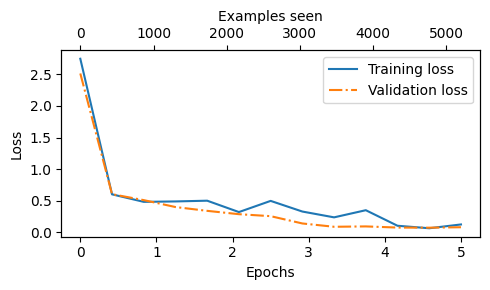

In [18]:
from spam_classifier_utils import plot_values

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

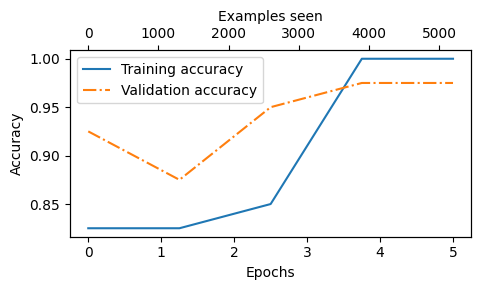

In [19]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))

plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")

## 7) Using the finetuned LLM as a SPAM classifier

In [20]:
from spam_classifier_utils import classify_review

In [21]:
text_1 = (
    "Congratulations! You have WON a $500 Amazon gift card"
    " in our exclusive lucky draw!"
)

print(classify_review(text_1, model, tokenizer, device, pad_length=train_dataset._longest_encoded_length))

Positive


In [22]:
text_2 = (
    "Reminder: School Parent-Teacher meeting tonight at 7 PM in the main "
    "auditorium. We look forward to seeing you there and discussing your "
    "child's progress."
)

print(classify_review(text_2, model, tokenizer, device))

Negative


In [23]:
torch.save(model.state_dict(), "review_classifier.pth")